<b><font size="+3">Финальный проект для курса "Otus Data Science"</font></b>

<font size="+2">Этап С: Обучение модели для игры в простую настольную игру ("Connect Four")</font> 




# План исследования:
    Этап A. исследование методов обучения с подкреплением на простой модели (OpenAI Gym Cartpole)
    
    Этап В. Построение и оптимизация модели работающей с видео выходом (OpenAI Gym Racer)
    
    Этап С. Обучение модели для игры в простую настольную игру ("Connect Four")

По примеру учёных из Deepmind, научивших нейросеть играть в Го, я решил попробовать обучить нейросеть игре "Четыре в ряд". 

**Правила**

Четыре в ряд или Connect four — игра для двоих, в которой игроки сначала выбирают цвет фишек, а затем ходят по очереди, роняя фишки в ячейки вертикальной доски. Цель игры — расположить раньше противника подряд по горизонтали, вертикали или диагонали четыре фишки своего цвета. 

описание: https://ru.wikipedia.org/wiki/%D0%A7%D0%B5%D1%82%D1%8B%D1%80%D0%B5_%D0%B2_%D1%80%D1%8F%D0%B4

![COMMECT FOUR](connect_four.jpg)

Для игры были созданы:
- **игровая арена** (модуль `game`), который содержит класс `Game4` работающий похоже на environments из OpenAI Gym. 
- **боты** (модуль `bots`) разного уровня продвинутости для поединков с ними на арене.
    1. `bots.Bot` - делает случайные ходы
    2. `bots.Bot1` - просчитывает победу на 1 ход вперёд.
    3. `bots.Bot3` - просчитывает победу или поражение на 3 хода вперёд. (*наиболее сильный бот*)
    4. `bots.Bot_Same_Col` - ходит только в один столбец пока тот не заполнится
    

Агент проводит множество поединков с ботами на арене и обучается на результатах.

Целью этого этапа проекта является обучение агента до степени превосходства над ботами.

**выводы**

Получается обучить агента побеждать в большинстве матчей с ботами. Для этого требуются тысячи матчей и низкий коэффициент обучения (`LR=0.0002`).

Что интересно, наиболее сильного бота удаётся побеждать в 100% случаев, возможно ввиду ограниченности количества его оптимальных тактик.

Недостатком является слабость обученных агентов в поедигках с иными ботами, в том числе сболее слабыми, чем тот, который использовался в обучении. 

# Setup

## imports

In [58]:
import numpy as np
import random
import math
import time
import copy
from itertools import zip_longest
from importlib import reload

import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm_notebook
plt.rcParams["figure.figsize"] = (18, 5)

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
Tensor = torch.Tensor
LongTensor = torch.LongTensor

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Torch: {torch.__version__}, device: {device}")

Torch: 1.2.0, device: cuda


In [4]:
import game
import bots
# from game import *
# from bots import *
# game.players
number_of_inputs = 42*3
number_of_outputs = 7

## Aux functions

In [5]:
def get_running_average(series, window):
    if not isinstance(series, np.ndarray):
        series = np.array(series)
    N = len(series)
    running_avg = np.empty(N)
    for t in range(N):
        running_avg[t] = series[max(0, t-window):(t+1)].mean()
    return running_avg


def plot_running_avg(series, window=20, show_range=None, title="Running Average", color='green'):
    running_avg = get_running_average(series, window)
    if show_range is not None:
        running_avg = running_avg[show_range[0]:show_range[1]]

    plt.plot(running_avg, color=color)
    plt.yticks([0, 50, 100])
    plt.grid()
    plt.title(title, fontsize=18)

    plt.show()

In [59]:
def transform_field(f):
    '''
    transform field encoded with players codes into 3 boolean arrays 6x7:
    Player0 chips, player1 chips, any chips
    for feeding to NN
    '''
    return np.concatenate((f==1, f== -1, f!=0)).astype(int).flatten()

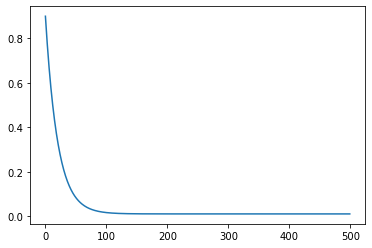

In [7]:
"""Epsilon adjustment"""
egreedy = 0.9
egreedy_final = 0.01
egreedy_decay = 20

def calculate_epsilon(steps_done):
    epsilon = egreedy_final + (egreedy - egreedy_final) * \
        math.exp(-1. * steps_done / egreedy_decay)
    return epsilon

plt.plot([calculate_epsilon(s) for s in range (500)])

In [8]:
def game_analyze(game, verbose = False):
    """ takes game record and inserts rewards for interim moves
    based on the final reward"""
    norm_reward = 0.2
    scale_factor = 50
    end_score = game[-1][3] // scale_factor
    steps = len(game)
    if verbose:
        print (f"steps:{steps}, end_score:{end_score}")
    
    for s in range(steps):
        game[s][3] = norm_reward # reset rewards
    
    game[-1][3] = end_score
    game[-2][3] = end_score / 2
    game[-3][3] = end_score / 4
        
        
def game_analyze0(game, verbose = False):
    """ takes game record and inserts rewards for interim moves
    based on the final reward"""
#     dr = 0.9
    end_score = game[-1][3]
    steps = len(game)
    if verbose:
        print (f"steps:{steps}, end_score:{end_score}")
    for s in range(steps):
        n = steps - s -1
        score = end_score * dr [n]
        if verbose:
            print (f"s:{s}, n:{n} score:{score:.2f}")
        game[s][3] = score

In [9]:
def f2str(f):
    """ converts 6*7 ndaray to string. -1 replaced by '2'"""
    f2 = np.array_str((f == -1)*3 + f)
    return ''.join(c for c in f2 if c.isdigit())


def state2str(s):
    """ converts [126,] ndaray to string. -1 replaced by '2'"""
    s2 = np.array_str(s[:42]+2*s[42:84])
    return ''.join(c for c in s2 if c.isdigit())


In [10]:
discount = 0.9
dr = [discount**n for n in range (42)]

## Replay Memory

In [60]:
class ReplayMemory(object):
    """ basic replay memory class """
    
    def __init__(self, capacity=10000):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, state, action, new_state, reward, done):
        transition = (state, action, new_state, reward, done)

        if self.position >= len(self.memory):
            self.memory.append(transition)
        else:
            self.memory[self.position] = transition

        self.position = (self.position + 1) % self.capacity

    def push_batch (self, batch):
        for state, action, new_state, reward, done in batch:
            self.push (state, action, new_state, reward, done)
        
    def sample(self, batch_size):
        return zip(*random.sample(self.memory, batch_size))

    def __len__(self):
        return len(self.memory)

In [13]:
class ReplayMemory_D1(object):
    """ replay memory with dictionary"""
    
    def __init__(self, capacity=10000):
        self.capacity = capacity
        self.memory = {}
#         self.position = 0

    def push(self, state, action, new_state, reward, done):
        transition = (state, action, new_state, reward, done)
        key = state2str(state)
        self.memory[key] = transition

    def push_batch (self, batch):
        for state, action, new_state, reward, done in batch:
            self.push (state, action, new_state, reward, done)
        
    def sample(self, batch_size):
        return zip(*random.sample(list(self.memory.values()), batch_size))

    def __len__(self):
        return len(self.memory)

In [14]:
class ReplayMemory3(ReplayMemory):
    """ variant with separate list of keys for deduplication"""
    def __init__(self, capacity=10000):
        self.capacity = capacity
        self.memory = []
        self.keys=[]
        self.position = 0

    def push(self, state, action, new_state, reward, done):
        transition = (state, action, new_state, reward, done)

        key = state2str(state)
        if key in self.keys:
            self.memory[key] = transition # replace by more recent experience
#             return  # used to ignore newer experiences
            

        if self.position >= len(self.memory):
            self.memory.append(transition)
            self.keys.append(key)
        else:
            self.memory[self.position] = transition
            self.keys[self.position] = key
        self.position = (self.position + 1) % self.capacity


class ReplayMemory4():
    """ separate memories for positive and negative experiences """
    def __init__(self, capacity=10000):
        self.capacity = capacity
        self.positives = ReplayMemory3(capacity=capacity//2)
        self.negatives = ReplayMemory3(capacity=capacity//2)

    def push_batch (self, batch):
        posi_batch = [b for b in batch if b[3]>=0]
        nega_batch = [b for b in batch if b[3]<0]
        self.positives.push_batch(posi_batch)
        self.negatives.push_batch(nega_batch)
    
    def push(self, state, action, new_state, reward, done):
        raise NotimplementedError
        
    def sample(self, batch_size):
        posi_size = min (len(self.positives), batch_size//2)
        nega_size = min (len(self.negatives), batch_size - posi_size)
        if nega_size < batch_size //2:
            posi_size = batch_size - nega_size
        posi_sample = list(self.positives.sample(posi_size))
        nega_sample = list(self.negatives.sample(nega_size))
        return [p+n for p, n in zip_longest (posi_sample, nega_sample)]
#         return posi_sample + nega_sample
                
    def __len__(self):
#         return self.positives.__len__() + self.negatives.__len__()
        return min(self.positives.__len__(), self.negatives.__len__())*2

class ReplayMemory4d(ReplayMemory4):
    """ separate memories for positive and negative experiences based on dictionaries"""
    def __init__(self, capacity=10000):
        self.capacity = capacity
        self.positives = ReplayMemory_D1(capacity=capacity//2)
        self.negatives = ReplayMemory_D1(capacity=capacity//2)


## Neural Networks

In [18]:
""" Defining linear NN with FC layers as specified in `hidden` parameter (as list) """

activations = {'relu': nn.ReLU, 'tanh': nn.Tanh}

class NN_Linear(nn.Module):
    def __init__(self, hidden, inputs=number_of_inputs, outputs=number_of_outputs, 
                 activation='relu'):
        super(NN_Linear, self).__init__()

        layers = [inputs] + hidden + [outputs]
        layers_number = len(layers) - 1

        self.fc_list= nn.ModuleList()
        for i in range (layers_number):
            self.fc_list.append(nn.Linear(layers[i],layers[i+1]))

        self.activation = activations[activation]()

    def forward(self, x):
        out = self.fc_list[0](x)
        for i in range (1, self.fc_list.__len__()):
            out = self.activation(out)
            out = self.fc_list[i](out)
        return out

In [20]:
""" NN with convolution layers"""

class Net_C1(nn.Module):
    def __init__(self):
        super(Net_C1, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, (4, 4))
        self.fc1 = nn.Linear(192, 480)
        self.fc2 = nn.Linear(480, 42)
        self.fc3 = nn.Linear(42, 7)

    def forward(self, x):
        x = x.view(-1, 3,7,6)
        x = F.relu(self.conv1(x))
#         print(self.num_flat_features(x))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

class Net_C2(nn.Module):
    def __init__(self):
        super(Net_C2, self).__init__()
        self.conv1 = nn.Conv2d(3, 160, (4, 4))
        self.fc1 = nn.Linear(1920, 480)
        self.fc2 = nn.Linear(480, 120)
        self.fc2b = nn.Linear(120, 120)
        self.fc3 = nn.Linear(120, 42)
        self.fc4 = nn.Linear(42, 7)

    def forward(self, x):
        x = x.view(-1, 3,7,6)
        x = F.relu(self.conv1(x))
#         print(self.num_flat_features(x))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc2b(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [22]:
""" utility functions to store/load successfl models """

def load_model(file):
    return torch.load(file)

def save_model(model, file):
    torch.save(model.state_dict(), file)

## Agent

In [23]:
class Agent_DQN(object):    
    """
    Universal Deep Q learning agent
    that plays "Connect four"
    """
    
    def __init__(self, name, net, optimizer="adam", lr=0.01, batch_size=32,
                 double_dqn=False, clip_error=True, update_target_frequency=500,
                 gamma=0.9999, loss_func='smooth_l1'):
        self.name = name
        
        # defining agent design and parameters
        self.double_dqn = double_dqn
        self.clip_error = clip_error
        self.batch_size = batch_size
        self.gamma = gamma
        self.type = 'agent'  # for differentiation at gym/lab
        
        # intialize neural networks and update mechanism 
        self.nn = net.to(device)
        self.target_nn = copy.deepcopy(self.nn).to(device)
        self.update_target_frequency = update_target_frequency
        self.update_target_counter = 0
        
        # initializing uax
        self.memory = ReplayMemory(capacity=50000)
        self.history={'name':self.name, }  # 'score':[]

        # initialize loss function
        loss_functions = {'mse': nn.MSELoss, 'smooth_l1': nn.SmoothL1Loss}
        self.loss_func = loss_functions[loss_func]()

        # initialize optimizer
        if optimizer == 'sgd':
            self.optimizer = optim.SGD(
                params=self.nn.parameters(), lr=lr, momentum=0.9)
        elif optimizer == 'rmsprop':
            self.optimizer = optim.RMSprop(params=self.nn.parameters(), lr=lr)
        else:
            self.optimizer = optim.Adam(params=self.nn.parameters(), lr=lr)
        

    def select_action(self, state, epsilon=0):
        if torch.rand(1)[0] > epsilon:
            with torch.no_grad():
                state = Tensor(state).to(device)
                action_from_nn = self.nn(state)
                action = torch.max(action_from_nn, -1).indices.item()
        else:
            action = random.randint(0,6) #env.action_space.sample()
        return action

    def move(self, f, d, active_player):
        return self.select_action(f * active_player)
    
    
    def optimize(self, verbose = False):
        if len(self.memory) < self.batch_size:
            return
        sample = self.memory.sample(self.batch_size)
        self.optimize_engine(sample, verbose)

   
    def optimize_engine(self, sample, verbose = False):
        """ optimization routine
        optimizes self.nn weights based on 1 run of sample batch
        sample: tuple (state, action, new_state, reward, done)
        sample dimensions = (batch_size, state dimension(s))
        """
        
        state, action, new_state, reward, done = sample
    
        state = Tensor(state).to(device)
        new_state = Tensor(new_state).to(device)
        reward = Tensor(reward).to(device)
        action = LongTensor(action).to(device)
        done = Tensor(done).to(device)

        if self.double_dqn:
            new_state_indexes = self.nn(new_state).detach()
            max_new_state_indexes = torch.max(new_state_indexes, 1)[1]

            new_state_values = self.target_nn(new_state).detach()
            max_new_state_values = new_state_values.gather(
                1, max_new_state_indexes.unsqueeze(1)).squeeze(1)
        else:
            new_state_values = self.target_nn(new_state).detach()
            max_new_state_values = torch.max(new_state_values, 1)[0]

        target_value = reward + (1 - done) * self.gamma * max_new_state_values  # Bellman Equation
        predicted_value = self.nn(state).gather(1, action.unsqueeze(1)).squeeze(1)

        loss = self.loss_func(predicted_value, target_value)
        self.optimizer.zero_grad()
        loss.backward()

        if self.clip_error: # limit error - idea from Deepmind’s paper:
            for param in self.nn.parameters():
                param.grad.data.clamp_(-1, 1)

        self.optimizer.step()

        if self.update_target_counter % self.update_target_frequency == 0:
            self.target_nn.load_state_dict(self.nn.state_dict())

        self.update_target_counter += 1

## Lab

In [40]:
def random_move(f):
    return random.randint(0, 6)


class Lab(object):
    """ Runs controlled matches of agents vs bots for testing and training """

    def __init__(self, bot=None):
        self.bot = bots.Bot1() if bot is None else bot  # Дежурный бот для тестов и обучения

    def test(self, agent, test_bot=None, verbose=1, num_games=100, report_interval=10,
             random_order=True):
        """
        tests net in fights vs bots
        verbose levels: 0=silent. just return win%, 1=one line, 2=interval reports
        consider allowing test against list of bots
        """
        if test_bot is None:
            test_bot = self.bot

        env = game.Game4(p0=test_bot, p1=bots.Player(name=agent.name), verbose=0, random_order=random_order)

        if verbose >= 1:
            print(f"testing agent '{agent.name}' with bot {test_bot.name}...")

        start_time = time.time()
        scores = []

        for i_match in range(1, num_games+1):
            result, _ = self.match(env, agent, )
            scores.append(result)
            elapsed_time = time.time() - start_time

            if i_match % report_interval == 0 and verbose >= 2:
                print(f"Matches: {i_match}; "
                      f"Last {report_interval} average: "
                      f"{sum(scores[-report_interval:])/report_interval:.1f}; "
                      "Elapsed:", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

        win_percent = len([s for s in scores if s == 100]) / num_games
        if verbose >= 1:
            print(
                f"Elapsed {elapsed_time:.2f}s, per match:{elapsed_time/i_match:.2f}s,")
            print(
                f"Agent '{agent.name}' won {win_percent*100:.1f}% games"
                f" against bot '{test_bot.name}' of {type(test_bot)}")

        return win_percent  # consider returning test history

    def train(self, agent, train_bot=None, verbose=1, num_games=1000,
              report_interval=100, eps_function=None, validation_bot=None,
              random_order=True):
        """
        trains agent's net in fights vs train_bot
        verbose levels: 0=silent. just return win%, 1=one line, 2=interval reports
        """
        if train_bot is None:
            train_bot = self.bot
        history = {'score': [], 'validation_score': [],
                   'train_bot': train_bot.name,
                   'validation_bot': validation_bot.name, }

        env = game.Game4(p0=train_bot, p1=bots.Player(name=agent.name),
                    verbose=0, random_order=random_order)

        if verbose >= 1:
            print(f"training for agent '{agent.name}' "
                  f"vs bot '{train_bot.name}' started...")

        start_time = time.time()
        scores = []

        for i_match in range(1, num_games+1):
            epsilon = calculate_epsilon(i_match)

            result, game_record = self.match(
                env, agent, epsilon, eps_function=eps_function, optimize=True)

            history['score'].append(result)
            elapsed_time = time.time() - start_time

            game_analyze(game_record)
            agent.memory.push_batch(game_record)

            if i_match % report_interval == 0 and verbose >= 2:

                print(f"Episode {i_match}: "
                      f"Last {report_interval} average: "
                      f"{sum(history['score'][-report_interval:])/report_interval:.1f}; "
                      f"Eps: {epsilon:.3f}; "
                      f"Elapsed: {time.strftime('%H:%M:%S', time.gmtime(elapsed_time))}",
                      end="")

                if validation_bot is not None:
                    validation_matches = 10
                    validation_percent = self.test(agent, test_bot=validation_bot, verbose=0,
                                                   num_games=validation_matches, random_order=random_order)
                    print(f"; validation wins: {validation_percent*100:.0f}%")
                else:
                    print()
                history['validation_score'].append(validation_percent)

        history['elapsed_time'] = elapsed_time
        history['matches'] = i_match

        if verbose >= 1:
            print(
                f"Elapsed {elapsed_time:.2f}s, per episode:{elapsed_time/i_match:.2f}s, ")

        agent.history.update(history)

        return   # consider returning train history

    def run_episode(self, env, agent, epsilon=0, eps_function=None, optimize=False):
        if eps_function is None:
            eps_function = random_move
        state = env.reset()
        moves_total = 0
        game_record = []

        while True:
            action = agent.select_action(state, 0)
            env_state, reward, done, info = env.step()
            if info == agent.name:
                game_record.append([state, action, new_state, reward, done])
            else:
                pass

            new_state = transform_field(env_state)  # use agent.transform_field
            game_record.append([state, action, new_state, reward, done])
            state = new_state

            if optimize:
                agent.optimize()

            if done:
                break
        agent.history['last_f'] = env_state
        return reward, game_record

    def match(self, env, agent, epsilon=0, eps_function=None, optimize=False):
        global env_state
        if eps_function is None:
            eps_function = random_move
        env_state = env.reset()
#         print ("SUM_STATE:", np.sum(env_state))
        moves_total = 0
        state = transform_field(env_state)  # use agent.transform_field
        game_record = []
        while True:
            moves_total += 1

            if torch.rand(1)[0] > epsilon:
                action = agent.select_action(state, 0)
            else:
                action = eps_function(f=env_state)
            env_state, reward, done, info = env.step(action)

            new_state = transform_field(env_state)  # use agent.transform_field
            game_record.append([state, action, new_state, reward, done])
            state = new_state

            if optimize:
                agent.optimize()

            if done:
                break
        agent.history['last_f'] = env_state
        return reward, game_record

In [28]:
""" bots for testing purposes"""
test_bot0 = bots.Bot("TestBot-0")
test_bot1 = bots.Bot1("TestBot-1")
test_bot3 = bots.Bot3("TestBot-3")

In [45]:
def bot3move(f):
    """ bot to play in training phase to generate positive experiences"""
    active_player = 1 if f.sum() == 0 else -1
    d =(f == 0).reshape((6, 7)).sum(axis=0)
    move = test_bot3.move(f, d=d, active_player=active_player)
    return move

# Tests

### training to beat bot 1

In [29]:
nc2b = Net_C2()
agent0 = Agent_DQN(name="Agent_0", net=nc2b,  lr=0.0002, update_target_frequency=1000)
agent0.memory = ReplayMemory4d(capacity=20000)

In [51]:
egreedy = 0.7
egreedy_final = 0
egreedy_decay = 40000

lab = Lab()
# eps_function=bot3move,
lab.train(agent0, train_bot=test_bot1, verbose=2, num_games=50000,
          eps_function=None, validation_bot=test_bot1,)

training for agent 'test_0' vs bot 'TestBot-1' started...
Episode 100: Last 100 average: -56.0; Eps: 0.792; Elapsed: 00:00:09; validation wins: 10%
Episode 200: Last 100 average: -62.0; Eps: 0.784; Elapsed: 00:00:19; validation wins: 40%
Episode 300: Last 100 average: -56.0; Eps: 0.776; Elapsed: 00:00:29; validation wins: 80%
Episode 400: Last 100 average: -54.0; Eps: 0.769; Elapsed: 00:00:40; validation wins: 30%
Episode 500: Last 100 average: -52.0; Eps: 0.761; Elapsed: 00:00:50; validation wins: 40%
Episode 600: Last 100 average: -59.0; Eps: 0.753; Elapsed: 00:01:01; validation wins: 30%
Episode 700: Last 100 average: -46.0; Eps: 0.746; Elapsed: 00:01:12; validation wins: 50%
Episode 800: Last 100 average: -70.0; Eps: 0.738; Elapsed: 00:01:22; validation wins: 50%
Episode 900: Last 100 average: -48.0; Eps: 0.731; Elapsed: 00:01:33; validation wins: 10%
Episode 1000: Last 100 average: -45.0; Eps: 0.724; Elapsed: 00:01:44; validation wins: 60%
Episode 1100: Last 100 average: -54.0; Ep

Episode 17900: Last 100 average: -4.0; Eps: 0.134; Elapsed: 00:39:18; validation wins: 80%
Episode 18000: Last 100 average: 0.0; Eps: 0.132; Elapsed: 00:39:34; validation wins: 50%
Episode 18100: Last 100 average: 6.0; Eps: 0.131; Elapsed: 00:39:49; validation wins: 60%
Episode 18200: Last 100 average: 10.0; Eps: 0.130; Elapsed: 00:40:04; validation wins: 60%
Episode 18300: Last 100 average: 10.0; Eps: 0.128; Elapsed: 00:40:20; validation wins: 90%
Episode 18400: Last 100 average: 4.0; Eps: 0.127; Elapsed: 00:40:37; validation wins: 50%
Episode 18500: Last 100 average: 14.0; Eps: 0.126; Elapsed: 00:40:53; validation wins: 40%
Episode 18600: Last 100 average: 10.0; Eps: 0.125; Elapsed: 00:41:09; validation wins: 80%
Episode 18700: Last 100 average: 12.0; Eps: 0.123; Elapsed: 00:41:24; validation wins: 40%
Episode 18800: Last 100 average: 2.0; Eps: 0.122; Elapsed: 00:41:39; validation wins: 50%
Episode 18900: Last 100 average: 12.0; Eps: 0.121; Elapsed: 00:41:56; validation wins: 70%
Epi

Episode 35900: Last 100 average: 35.0; Eps: 0.022; Elapsed: 01:33:44; validation wins: 40%
Episode 36000: Last 100 average: 24.0; Eps: 0.022; Elapsed: 01:34:05; validation wins: 20%
Episode 36100: Last 100 average: 34.0; Eps: 0.022; Elapsed: 01:34:25; validation wins: 40%
Episode 36200: Last 100 average: 36.0; Eps: 0.021; Elapsed: 01:34:47; validation wins: 50%
Episode 36300: Last 100 average: 34.0; Eps: 0.021; Elapsed: 01:35:07; validation wins: 80%
Episode 36400: Last 100 average: 32.0; Eps: 0.021; Elapsed: 01:35:29; validation wins: 70%
Episode 36500: Last 100 average: 34.0; Eps: 0.021; Elapsed: 01:35:50; validation wins: 70%
Episode 36600: Last 100 average: 10.0; Eps: 0.021; Elapsed: 01:36:11; validation wins: 70%
Episode 36700: Last 100 average: 34.0; Eps: 0.020; Elapsed: 01:36:32; validation wins: 70%
Episode 36800: Last 100 average: 24.0; Eps: 0.020; Elapsed: 01:36:53; validation wins: 70%
Episode 36900: Last 100 average: 41.0; Eps: 0.020; Elapsed: 01:37:14; validation wins: 100

In [130]:
save_model(nc2b, './nn/nc2b_trained_on_b1.tnn')

In [65]:
%time lab.test(agent0, test_bot=test_bot0)

testing by bot TestBot-0 for agent 'test_0'...
Elapsed 1.97s, per match:0.02s,
Agent 'test_0' won 85.0% games against bot 'TestBot-0' of <class 'bots.Bot'>
Wall time: 1.97 s


0.85

In [66]:
%time lab.test(agent0, test_bot=test_bot1)

testing by bot TestBot-1 for agent 'test_0'...
Elapsed 3.97s, per match:0.04s,
Agent 'test_0' won 75.0% games against bot 'TestBot-1' of <class 'bots.Bot1'>
Wall time: 3.97 s


0.75

In [35]:
lab.test(agent0, test_bot=test_bot3)

testing agent 'Agent_0' with bot QCJ-b3-A-002...
Elapsed 13.95s, per match:0.14s,
Agent 'Agent_0' won 0.0% games against bot 'QCJ-b3-A-002' of <class 'bots.Bot3'>
Wall time: 14 s


0.0

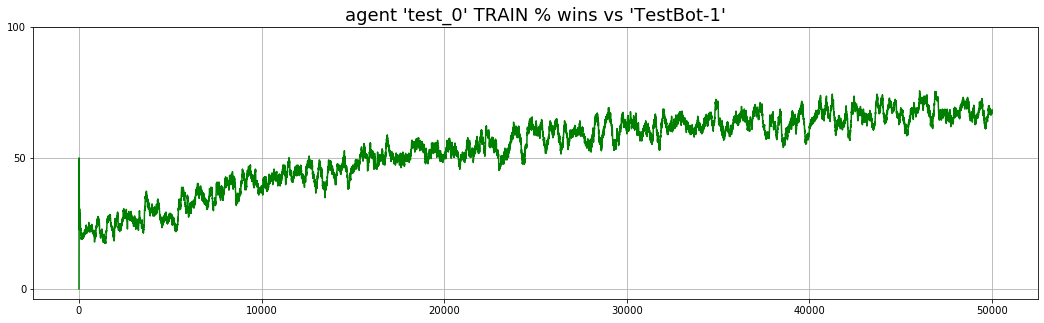

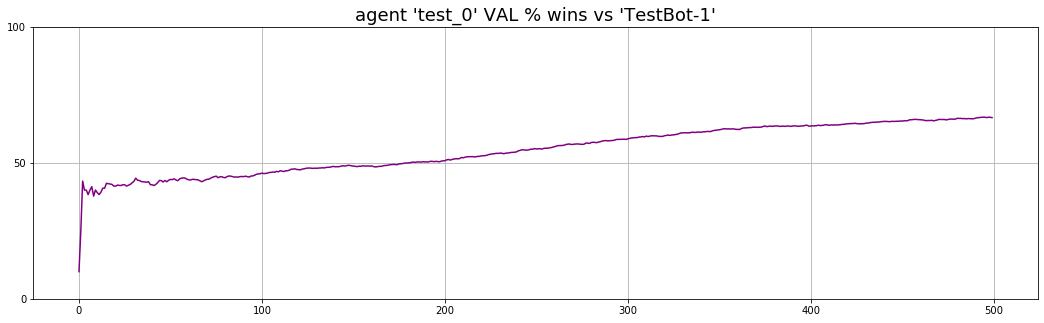

In [196]:
plot_agent = agent0
window = 200

train_bot = plot_agent.history['train_bot']
val_bot = plot_agent.history['validation_bot']

title0 = f"agent '{plot_agent.name}' TRAIN % wins vs '{train_bot}'"
title1 = f"agent '{plot_agent.name}' VAL % wins vs '{val_bot}'"

plot_running_avg([b/2+50 for b in plot_agent.history['score']],window=window, title=title0)
plot_running_avg([b*100 for b in plot_agent.history['validation_score']],window=window, title=title1, color='purple')

In [178]:
agent1.history['train_bot'] = test_bot3.name

### train to beat bot3

In [69]:
nc2c = Net_C2()
agent1 = Agent_DQN(name="test_0", net=nc2c,  lr=0.0002, update_target_frequency=1000)
agent1.memory = ReplayMemory4d(capacity=20000)

In [71]:
egreedy = 0.8
egreedy_final = 0
egreedy_decay = 10000

lab = Lab()

lab.train(agent1, train_bot=test_bot3, verbose=2, num_games=50000,
          eps_function=bot3move, validation_bot=test_bot1,)

training for agent 'test_0' vs bot 'YYG-b3-A-001' started...
Episode 100: Last 100 average: -72.0; Eps: 0.792; Elapsed: 00:01:02; validation wins: 40%
Episode 200: Last 100 average: -61.0; Eps: 0.784; Elapsed: 00:02:11; validation wins: 20%
Episode 300: Last 100 average: -62.0; Eps: 0.776; Elapsed: 00:03:25; validation wins: 40%
Episode 400: Last 100 average: -66.0; Eps: 0.769; Elapsed: 00:04:35; validation wins: 30%
Episode 500: Last 100 average: -34.0; Eps: 0.761; Elapsed: 00:05:49; validation wins: 30%
Episode 600: Last 100 average: -48.0; Eps: 0.753; Elapsed: 00:07:00; validation wins: 40%
Episode 700: Last 100 average: -34.0; Eps: 0.746; Elapsed: 00:08:14; validation wins: 30%
Episode 800: Last 100 average: -47.0; Eps: 0.738; Elapsed: 00:09:29; validation wins: 40%
Episode 900: Last 100 average: -61.0; Eps: 0.731; Elapsed: 00:10:42; validation wins: 20%
Episode 1000: Last 100 average: -61.0; Eps: 0.724; Elapsed: 00:11:57; validation wins: 40%
Episode 1100: Last 100 average: -50.0;

Episode 18100: Last 100 average: 93.0; Eps: 0.131; Elapsed: 03:02:32; validation wins: 30%
Episode 18200: Last 100 average: 85.0; Eps: 0.130; Elapsed: 03:03:26; validation wins: 70%
Episode 18300: Last 100 average: 83.0; Eps: 0.128; Elapsed: 03:04:21; validation wins: 0%
Episode 18400: Last 100 average: 85.0; Eps: 0.127; Elapsed: 03:05:15; validation wins: 20%
Episode 18500: Last 100 average: 78.0; Eps: 0.126; Elapsed: 03:06:10; validation wins: 30%
Episode 18600: Last 100 average: 89.0; Eps: 0.125; Elapsed: 03:07:05; validation wins: 30%
Episode 18700: Last 100 average: 80.0; Eps: 0.123; Elapsed: 03:08:00; validation wins: 30%
Episode 18800: Last 100 average: 86.0; Eps: 0.122; Elapsed: 03:08:55; validation wins: 30%
Episode 18900: Last 100 average: 87.0; Eps: 0.121; Elapsed: 03:09:49; validation wins: 40%
Episode 19000: Last 100 average: 92.0; Eps: 0.120; Elapsed: 03:10:44; validation wins: 40%
Episode 19100: Last 100 average: 90.0; Eps: 0.118; Elapsed: 03:11:38; validation wins: 50%


Episode 36000: Last 100 average: 100.0; Eps: 0.022; Elapsed: 05:42:07; validation wins: 30%
Episode 36100: Last 100 average: 100.0; Eps: 0.022; Elapsed: 05:42:59; validation wins: 30%
Episode 36200: Last 100 average: 78.0; Eps: 0.021; Elapsed: 05:43:51; validation wins: 30%
Episode 36300: Last 100 average: 96.0; Eps: 0.021; Elapsed: 05:44:43; validation wins: 30%
Episode 36400: Last 100 average: 82.0; Eps: 0.021; Elapsed: 05:45:35; validation wins: 20%
Episode 36500: Last 100 average: 94.0; Eps: 0.021; Elapsed: 05:46:28; validation wins: 30%
Episode 36600: Last 100 average: 94.0; Eps: 0.021; Elapsed: 05:47:22; validation wins: 10%
Episode 36700: Last 100 average: 96.0; Eps: 0.020; Elapsed: 05:48:15; validation wins: 30%
Episode 36800: Last 100 average: 94.0; Eps: 0.020; Elapsed: 05:49:09; validation wins: 20%
Episode 36900: Last 100 average: 96.0; Eps: 0.020; Elapsed: 05:50:03; validation wins: 20%
Episode 37000: Last 100 average: 94.0; Eps: 0.020; Elapsed: 05:50:57; validation wins: 5

In [131]:
save_model(nc2c, './nn/nc2c_trained_on_b3.tnn')

In [74]:
%time lab.test(agent1, test_bot=test_bot0)

testing by bot TestBot-0 for agent 'test_0'...
Elapsed 2.13s, per match:0.02s,
Agent 'test_0' won 44.0% games against bot 'TestBot-0' of <class 'bots.Bot'>
Wall time: 2.14 s


0.44

In [72]:
%time lab.test(agent1, test_bot=test_bot1)

testing by bot TestBot-1 for agent 'test_0'...
Elapsed 3.38s, per match:0.03s,
Agent 'test_0' won 24.0% games against bot 'TestBot-1' of <class 'bots.Bot1'>
Wall time: 3.38 s


0.24

In [73]:
%time lab.test(agent1, test_bot=test_bot3)

testing by bot YYG-b3-A-001 for agent 'test_0'...
Elapsed 35.28s, per match:0.35s,
Agent 'test_0' won 100.0% games against bot 'YYG-b3-A-001' of <class 'bots.Bot3'>
Wall time: 35.3 s


1.0

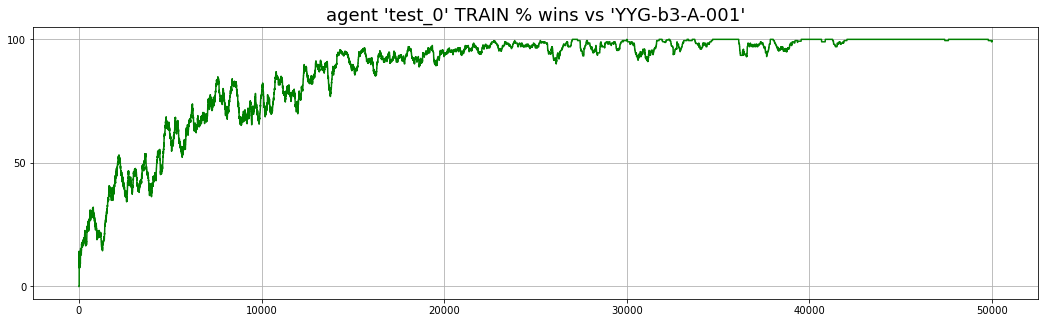

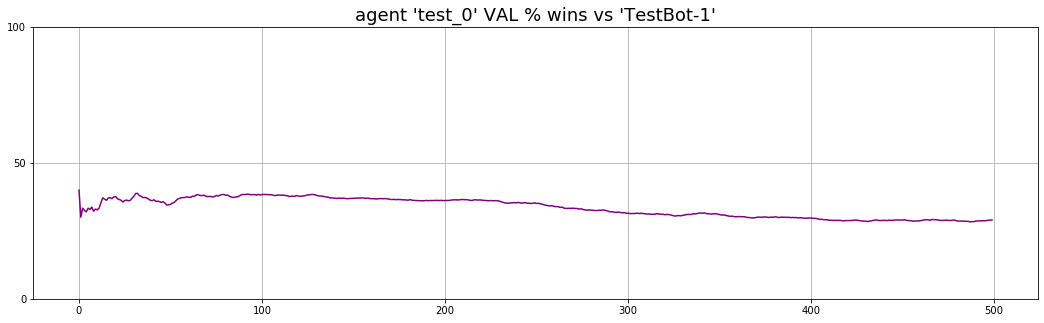

In [195]:
plot_agent = agent1
window = 200

train_bot = plot_agent.history['train_bot']
val_bot = plot_agent.history['validation_bot']

title0 = f"agent '{plot_agent.name}' TRAIN % wins vs '{train_bot}'"
title1 = f"agent '{plot_agent.name}' VAL % wins vs '{val_bot}'"

plot_running_avg([b/2+50 for b in plot_agent.history['score']],window=window, title=title0)
plot_running_avg([b*100 for b in plot_agent.history['validation_score']],window=window, title=title1, color='purple')

## more tests / drafts

In [343]:
reload(bots)

<module 'bots' from 'c:\\bigdata\\otus_data_science\\project\\bots.py'>

In [344]:
bmc_bot = bots.Bot_Min_Col('Min_Col_1')
bsc_bot = bots.Bot_Same_Col('Same_Col_1')

In [396]:
# nc2b2 = Net_C2()
# nc2b2.load_state_dict(load_model('./nn/nc2c_trained_on_b3.tnn'))

In [397]:
agent2 = Agent_DQN(name="Agent_2", net=Net_C2(),  lr=0.0005, update_target_frequency=1000)
agent2.memory = ReplayMemory4d(capacity=20000)

In [399]:
egreedy = 0.8
egreedy_final = 0
egreedy_decay = 10000

lab = Lab(bot=bsc_bot)
# eps_function=bot3move,
lab.train(agent2, train_bot=bsc_bot, verbose=2, num_games=20000,
          eps_function=None, validation_bot=bsc_bot, random_order=True)

training for agent 'Agent_2' vs bot 'BSC_002' started...
Episode 100: Last 100 average: -66.0; Eps: 0.792; Elapsed: 00:00:05; validation wins: 10%
Episode 200: Last 100 average: -78.0; Eps: 0.784; Elapsed: 00:00:11; validation wins: 30%
Episode 300: Last 100 average: -50.0; Eps: 0.776; Elapsed: 00:00:18; validation wins: 60%
Episode 400: Last 100 average: -50.0; Eps: 0.769; Elapsed: 00:00:25; validation wins: 80%
Episode 500: Last 100 average: -46.0; Eps: 0.761; Elapsed: 00:00:33; validation wins: 60%
Episode 600: Last 100 average: -54.0; Eps: 0.753; Elapsed: 00:00:41; validation wins: 60%
Episode 700: Last 100 average: -46.0; Eps: 0.746; Elapsed: 00:00:49; validation wins: 70%
Episode 800: Last 100 average: -10.0; Eps: 0.738; Elapsed: 00:00:57; validation wins: 80%
Episode 900: Last 100 average: -40.0; Eps: 0.731; Elapsed: 00:01:06; validation wins: 80%
Episode 1000: Last 100 average: -32.0; Eps: 0.724; Elapsed: 00:01:14; validation wins: 90%
Episode 1100: Last 100 average: -44.0; Eps

Episode 18100: Last 100 average: 41.0; Eps: 0.131; Elapsed: 00:41:42; validation wins: 70%
Episode 18200: Last 100 average: 32.0; Eps: 0.130; Elapsed: 00:42:04; validation wins: 40%
Episode 18300: Last 100 average: 30.0; Eps: 0.128; Elapsed: 00:42:31; validation wins: 80%
Episode 18400: Last 100 average: 33.0; Eps: 0.127; Elapsed: 00:43:00; validation wins: 80%
Episode 18500: Last 100 average: 29.0; Eps: 0.126; Elapsed: 00:43:29; validation wins: 80%
Episode 18600: Last 100 average: 45.0; Eps: 0.125; Elapsed: 00:43:55; validation wins: 80%
Episode 18700: Last 100 average: 32.0; Eps: 0.123; Elapsed: 00:44:22; validation wins: 50%
Episode 18800: Last 100 average: 56.0; Eps: 0.122; Elapsed: 00:45:05; validation wins: 80%
Episode 18900: Last 100 average: 37.0; Eps: 0.121; Elapsed: 00:45:34; validation wins: 70%
Episode 19000: Last 100 average: 45.0; Eps: 0.120; Elapsed: 00:46:09; validation wins: 60%
Episode 19100: Last 100 average: 28.0; Eps: 0.118; Elapsed: 00:46:41; validation wins: 90%

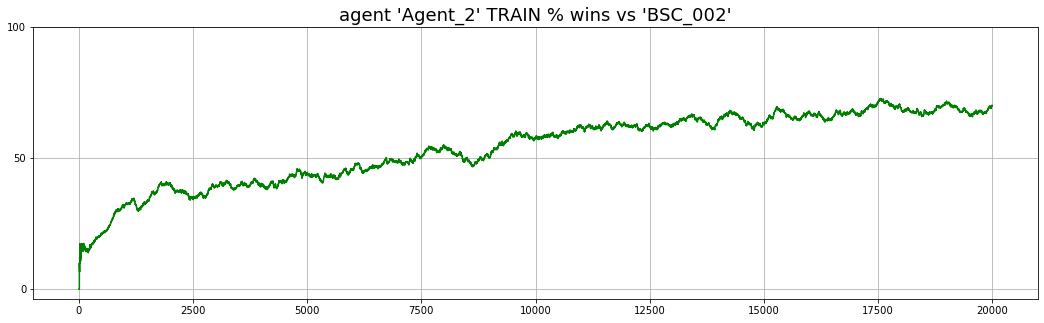

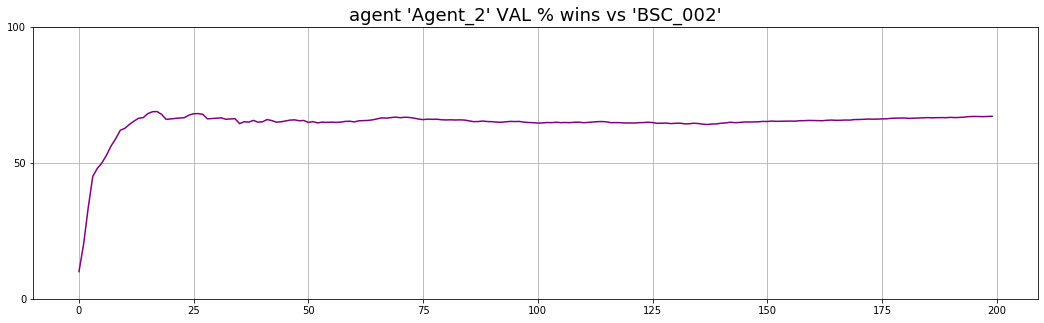

In [400]:
plot_agent = agent2
window = 500

train_bot = plot_agent.history['train_bot']
val_bot = plot_agent.history['validation_bot']

title0 = f"agent '{plot_agent.name}' TRAIN % wins vs '{train_bot}'"
title1 = f"agent '{plot_agent.name}' VAL % wins vs '{val_bot}'"

plot_running_avg([b/2+50 for b in plot_agent.history['score']],
                 window=window, title=title0)
plot_running_avg([b*100 for b in plot_agent.history['validation_score']],
                 window=window, title=title1, color='purple')

In [386]:
reload(game)

<module 'game' from 'c:\\bigdata\\otus_data_science\\project\\game.py'>

In [389]:
print_field(f, color=False)

 ● ● ○ . . . ● 
 ● ● ● . . . ● 
 ○ ○ ○ ● . . ● 
 ● ● ● ○ . ○ ○ 
 ● ● ○ ○ . ○ ● 
 ● ● ○ ○ . ○ ● 
 0 1 2 3 4 5 6 


In [226]:
%time lab.test(agent2, test_bot=test_bot3, num_games=50)

testing agent 'Agent_2' with bot YYG-b3-A-001...
Elapsed 15.97s, per match:0.16s,
Agent 'Agent_2' won 0.0% games against bot 'YYG-b3-A-001' of <class 'bots.Bot3'>
Wall time: 16 s


0.0

In [228]:
%time lab.test(agent2, test_bot=test_bot1, num_games=50)

testing agent 'Agent_2' with bot TestBot-1...
Elapsed 1.68s, per match:0.03s,
Agent 'Agent_2' won 44.0% games against bot 'TestBot-1' of <class 'bots.Bot1'>
Wall time: 1.68 s


0.44

In [403]:
agent3 = Agent_DQN(name="Agent_3", net=Net_C2(),  lr=0.0002, update_target_frequency=500)
agent3.memory = ReplayMemory4d(capacity=20000)

In [409]:
egreedy = 0.8
egreedy_final = 0
egreedy_decay = 30000

lab = Lab()
# eps_function=bot3move,
lab.train(agent3, train_bot=test_bot1, verbose=2, num_games=50000,
          eps_function=None, validation_bot=test_bot1, random_order=True)

training for agent 'Agent_3' vs bot 'TestBot-1' started...
Episode 100: Last 100 average: -36.0; Eps: 0.797; Elapsed: 00:00:10; validation wins: 60%
Episode 200: Last 100 average: -52.0; Eps: 0.795; Elapsed: 00:00:21; validation wins: 30%
Episode 300: Last 100 average: -54.0; Eps: 0.792; Elapsed: 00:00:32; validation wins: 20%
Episode 400: Last 100 average: -42.0; Eps: 0.789; Elapsed: 00:00:42; validation wins: 50%
Episode 500: Last 100 average: -46.0; Eps: 0.787; Elapsed: 00:00:53; validation wins: 20%
Episode 600: Last 100 average: -40.0; Eps: 0.784; Elapsed: 00:01:04; validation wins: 40%
Episode 700: Last 100 average: -40.0; Eps: 0.782; Elapsed: 00:01:16; validation wins: 40%
Episode 800: Last 100 average: -60.0; Eps: 0.779; Elapsed: 00:01:28; validation wins: 80%
Episode 900: Last 100 average: -34.0; Eps: 0.776; Elapsed: 00:01:39; validation wins: 40%
Episode 1000: Last 100 average: -20.0; Eps: 0.774; Elapsed: 00:01:51; validation wins: 20%
Episode 1100: Last 100 average: -45.0; E

Episode 17900: Last 100 average: -16.0; Eps: 0.441; Elapsed: 00:38:51; validation wins: 40%
Episode 18000: Last 100 average: -26.0; Eps: 0.439; Elapsed: 00:39:05; validation wins: 40%
Episode 18100: Last 100 average: -34.0; Eps: 0.438; Elapsed: 00:39:21; validation wins: 50%
Episode 18200: Last 100 average: -26.0; Eps: 0.436; Elapsed: 00:39:35; validation wins: 40%
Episode 18300: Last 100 average: -28.0; Eps: 0.435; Elapsed: 00:39:49; validation wins: 50%
Episode 18400: Last 100 average: -18.0; Eps: 0.433; Elapsed: 00:40:04; validation wins: 30%
Episode 18500: Last 100 average: -18.0; Eps: 0.432; Elapsed: 00:40:19; validation wins: 40%
Episode 18600: Last 100 average: -34.0; Eps: 0.430; Elapsed: 00:40:33; validation wins: 40%
Episode 18700: Last 100 average: -10.0; Eps: 0.429; Elapsed: 00:40:48; validation wins: 50%
Episode 18800: Last 100 average: -36.0; Eps: 0.427; Elapsed: 00:41:03; validation wins: 50%
Episode 18900: Last 100 average: -30.0; Eps: 0.426; Elapsed: 00:41:17; validatio

Episode 35800: Last 100 average: 24.0; Eps: 0.243; Elapsed: 01:25:51; validation wins: 60%
Episode 35900: Last 100 average: 16.0; Eps: 0.242; Elapsed: 01:26:08; validation wins: 70%
Episode 36000: Last 100 average: 22.0; Eps: 0.241; Elapsed: 01:26:26; validation wins: 80%
Episode 36100: Last 100 average: -2.0; Eps: 0.240; Elapsed: 01:26:43; validation wins: 70%
Episode 36200: Last 100 average: 2.0; Eps: 0.239; Elapsed: 01:27:00; validation wins: 80%
Episode 36300: Last 100 average: 4.0; Eps: 0.239; Elapsed: 01:27:18; validation wins: 60%
Episode 36400: Last 100 average: 6.0; Eps: 0.238; Elapsed: 01:27:35; validation wins: 60%
Episode 36500: Last 100 average: 2.0; Eps: 0.237; Elapsed: 01:27:53; validation wins: 60%
Episode 36600: Last 100 average: -8.0; Eps: 0.236; Elapsed: 01:28:11; validation wins: 40%
Episode 36700: Last 100 average: 8.0; Eps: 0.235; Elapsed: 01:28:28; validation wins: 50%
Episode 36800: Last 100 average: -22.0; Eps: 0.235; Elapsed: 01:28:45; validation wins: 40%
Epi

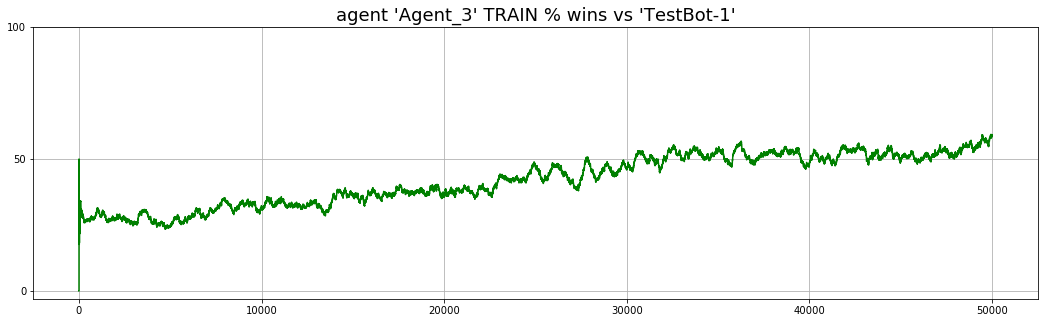

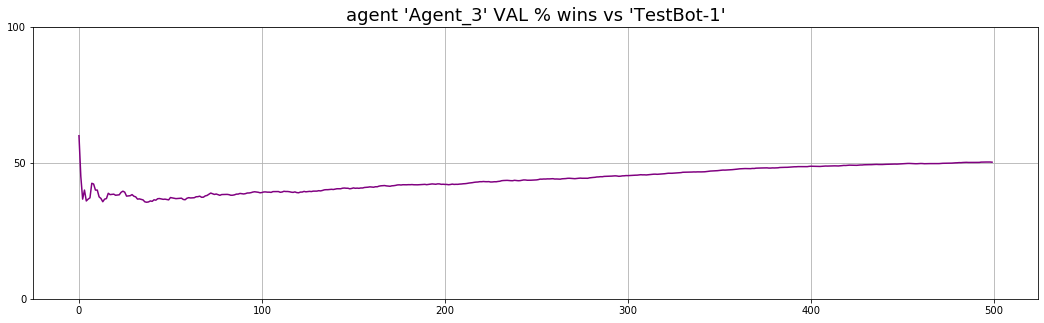

In [410]:
plot_agent = agent3
window = 500

train_bot = plot_agent.history['train_bot']
val_bot = plot_agent.history['validation_bot']

title0 = f"agent '{plot_agent.name}' TRAIN % wins vs '{train_bot}'"
title1 = f"agent '{plot_agent.name}' VAL % wins vs '{val_bot}'"

plot_running_avg([b/2+50 for b in plot_agent.history['score']],
                 window=window, title=title0)
plot_running_avg([b*100 for b in plot_agent.history['validation_score']],
                 window=window, title=title1, color='purple')

In [52]:
agent4 = Agent_DQN(name="Agent_4", net=Net_C2(),  lr=0.001, update_target_frequency=500)
agent4.memory = ReplayMemory4d(capacity=20000)

In [53]:
egreedy = 0.8
egreedy_final = 0
egreedy_decay = 20000

lab = Lab()
# eps_function=bot3move,
lab.train(agent4, train_bot=test_bot0, verbose=2, num_games=30000,
          eps_function=None, validation_bot=test_bot0, random_order=True)

training for agent 'Agent_4' vs bot 'TestBot-0' started...
Episode 100: Last 100 average: 1.0; Eps: 0.796; Elapsed: 00:00:09; validation wins: 40%
Episode 200: Last 100 average: 1.0; Eps: 0.792; Elapsed: 00:00:20; validation wins: 60%
Episode 300: Last 100 average: 0.0; Eps: 0.788; Elapsed: 00:00:31; validation wins: 80%
Episode 400: Last 100 average: 6.0; Eps: 0.784; Elapsed: 00:00:42; validation wins: 60%
Episode 500: Last 100 average: -10.0; Eps: 0.780; Elapsed: 00:00:52; validation wins: 50%
Episode 600: Last 100 average: -14.0; Eps: 0.776; Elapsed: 00:01:04; validation wins: 40%
Episode 700: Last 100 average: -14.0; Eps: 0.772; Elapsed: 00:01:14; validation wins: 70%
Episode 800: Last 100 average: -4.0; Eps: 0.769; Elapsed: 00:01:25; validation wins: 60%
Episode 900: Last 100 average: -12.0; Eps: 0.765; Elapsed: 00:01:37; validation wins: 40%
Episode 1000: Last 100 average: -23.0; Eps: 0.761; Elapsed: 00:01:48; validation wins: 60%
Episode 1100: Last 100 average: -2.0; Eps: 0.757;

Episode 18100: Last 100 average: 5.0; Eps: 0.324; Elapsed: 00:39:16; validation wins: 50%
Episode 18200: Last 100 average: -4.0; Eps: 0.322; Elapsed: 00:39:31; validation wins: 80%
Episode 18300: Last 100 average: 16.0; Eps: 0.320; Elapsed: 00:39:45; validation wins: 70%
Episode 18400: Last 100 average: -6.0; Eps: 0.319; Elapsed: 00:40:01; validation wins: 60%
Episode 18500: Last 100 average: 8.0; Eps: 0.317; Elapsed: 00:40:15; validation wins: 40%
Episode 18600: Last 100 average: -13.0; Eps: 0.316; Elapsed: 00:40:30; validation wins: 40%
Episode 18700: Last 100 average: 18.0; Eps: 0.314; Elapsed: 00:40:43; validation wins: 80%
Episode 18800: Last 100 average: -7.0; Eps: 0.313; Elapsed: 00:40:59; validation wins: 40%
Episode 18900: Last 100 average: -4.0; Eps: 0.311; Elapsed: 00:41:13; validation wins: 60%
Episode 19000: Last 100 average: 16.0; Eps: 0.309; Elapsed: 00:41:29; validation wins: 60%
Episode 19100: Last 100 average: 14.0; Eps: 0.308; Elapsed: 00:41:44; validation wins: 50%


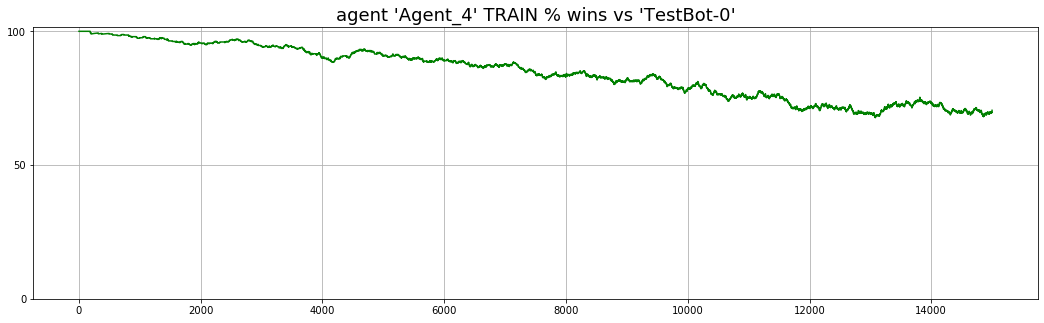

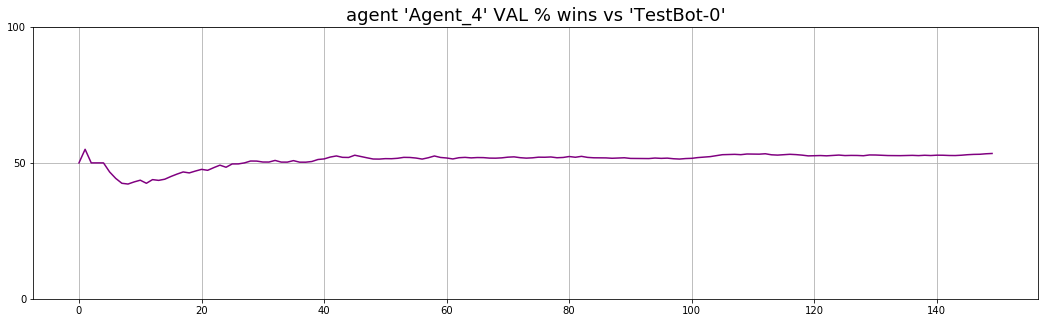

In [51]:
plot_agent = agent4
window = 500

train_bot = plot_agent.history['train_bot']
val_bot = plot_agent.history['validation_bot']

title0 = f"agent '{plot_agent.name}' TRAIN % wins vs '{train_bot}'"
title1 = f"agent '{plot_agent.name}' VAL % wins vs '{val_bot}'"

plot_running_avg([b/2+50 for b in plot_agent.history['score']],
                 window=window, title=title0)
plot_running_avg([b*100 for b in plot_agent.history['validation_score']],
                 window=window, title=title1, color='purple')